# 4.2 HS Improves Prediction Performance for Commonly Used Tree Methods

In [21]:
# imports
%load_ext autoreload
%autoreload 2
import os
import sys

import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier

import numpy as np
import pandas as pd

import imodels
from imodels.util.data_util import get_clean_dataset # this was used to get the datasets

from copy import deepcopy

# cross-validation of models
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import plotnine
from plotnine import ggplot, aes, geom_line, geom_point, geom_errorbar, facet_wrap, position_dodge, theme

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Repositories used for tests (location: paper_autors_repo/config/shrinkage/models.py) - tuki sem skopiral samo ker je lazje najti

DATASETS_CLASSIFICATION = [
    # classification datasets from original random forests paper
    # page 9: https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf
    # ("sonar", "sonar", "pmlb"),
    ("heart", "heart", 'imodels'),
    ("breast-cancer", "breast_cancer", 'imodels'), # this is the wrong breast-cancer dataset (https://new.openml.org/search?type=data&sort=runs&id=13&status=active)
    ("haberman", "haberman", 'imodels'),
    ("ionosphere", "ionosphere", 'pmlb'),
    ("diabetes", "diabetes", "pmlb"),
    # ("liver", "8", "openml"), # note: we omit this dataset bc it's label was found to be incorrect (see caveat here: https://archive.ics.uci.edu/ml/datasets/liver+disorders#:~:text=The%207th%20field%20(selector)%20has%20been%20widely%20misinterpreted%20in%20the%20past%20as%20a%20dependent%20variable%20representing%20presence%20or%20absence%20of%20a%20liver%20disorder.)
    # ("credit-g", "credit_g", 'imodels'), # like german-credit, but more feats
    ("german-credit", "german", "pmlb"),

    # clinical-decision rules
    # ("iai-pecarn", "iai_pecarn.csv", "imodels"),

    # popular classification datasets used in rule-based modeling / fairness
    # page 7: http://proceedings.mlr.press/v97/wang19a/wang19a.pdf
    ("juvenile", "juvenile_clean", 'imodels'),
    ("recidivism", "compas_two_year_clean", 'imodels'),
    # ("credit", "credit_card_clean", 'imodels'),
    # ("readmission", 'readmission_clean', 'imodels'),  # v big
]

DATASETS_REGRESSION = [
    # leo-breiman paper random forest uses some UCI datasets as well
    # pg 23: https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf
    ('friedman1', 'friedman1', 'synthetic'),
    ('friedman2', 'friedman2', 'synthetic'),
    ('friedman3', 'friedman3', 'synthetic'),
    ('abalone', '183', 'openml'),
    ("diabetes-regr", "diabetes", 'sklearn'),
    ("california-housing", "california_housing", 'sklearn'),  # this replaced boston-housing due to ethical issues
    ("satellite-image", "294_satellite_image", 'pmlb'),
    ("echo-months", "1199_BNG_echoMonths", 'pmlb'),
    ("breast-tumor", "1201_BNG_breastTumor", 'pmlb'),  # this one is v big (100k examples)

]

In [23]:
# number of leafs used in paper
num_of_leaves = [2, 4, 8, 12, 15, 20, 24, 28, 30, 32]
# reuglarization parameter
reg_hs = [0.1, 1.0, 10.0, 25.0, 50.0, 100.0]

## 4.2 A) Classification

In [24]:
tasks = {}

# load datasets
for task in DATASETS_CLASSIFICATION:
    X, y, feature_names = get_clean_dataset(task[1], data_source = task[2])
    df = pd.DataFrame(X, columns=feature_names)
    df["label"] = y
    tasks[task[0]] = df

In [39]:
def leaf_count(dt):
    tree = dt.tree_
    num_leaves = 0

    for i in range(tree.node_count):
        if tree.children_left[i] > 0 or tree.children_right[i] > 0:
            num_leaves += 1

    return num_leaves

def pick_alpha(X, y, number_of_leaves):
    path = DecisionTreeClassifier().cost_complexity_pruning_path(X, y)
    alphas = path["ccp_alphas"]

    leaf_cnts = []

    for alpha in alphas:
        mccp = DecisionTreeClassifier(ccp_alpha=alpha).fit(X, y)
        leaf_cnts.append(np.abs(number_of_leaves - leaf_count(mccp)))
    idx = np.argmin(leaf_cnts)

    return alphas[idx]
        

In [40]:
# Potential problem HS appeared to be choosen via CV (hopefully they split the dataset before hand)
NUM_OF_BOOTSTRAP_SAMPS = 10
classification_results = pd.DataFrame(columns = ["task", "dataset", "boot_iter", "algorithm", "scoring", "n_leaves", "max_leaves", "regularization", "train_score", "test_score"])

for task in DATASETS_CLASSIFICATION:
    for samp in range(NUM_OF_BOOTSTRAP_SAMPS):
        skf = StratifiedKFold(n_splits=3)
        X, y = np.array(tasks[task[0]].drop("label", axis = 1)), np.array(tasks[task[0]]["label"])
        for i, (train_index, test_index) in enumerate(skf.split(tasks[task[0]], tasks[task[0]]["label"])):
            print(f"Dataset: {task[0]}, Sample: {samp}, Fold {i}", end = "\r")

            X_train, y_train = X[train_index, :], y[train_index]
            X_test, y_test = X[test_index, :], y[test_index]

            for m in num_of_leaves:
                ### CART ###
                m1 = DecisionTreeClassifier(max_leaf_nodes=m).fit(X_train, y_train)
                y_train_pred_dt = m1.predict(X_train)
                y_test_pred_dt = m1.predict(X_test)

                classification_results = pd.concat([classification_results, pd.DataFrame({"task": ["classification"], 
                                                                            "dataset": [task[0]],
                                                                            "boot_iter": [samp],
                                                                            "algorithm": ["DT"],
                                                                            "scoring": ["AUC"],
                                                                            "n_leaves": [leaf_count(m1)],
                                                                            "max_leaves": [m],
                                                                            "regularization": ["None"],
                                                                            "train_score": [roc_auc_score(y_train, y_train_pred_dt)],
                                                                            "test_score": [roc_auc_score(y_test, y_test_pred_dt)]})])

                ### CART with CCP ###
                mccp = DecisionTreeClassifier(ccp_alpha=pick_alpha(X_train, y_train, m)).fit(X_train, y_train)
                y_train_pred_ccp = mccp.predict(X_train)
                y_test_pred_ccp = mccp.predict(X_test)

                classification_results = pd.concat([classification_results, pd.DataFrame({"task": ["classification"], 
                                                                            "dataset": [task[0]],
                                                                            "boot_iter": [samp],
                                                                            "algorithm": ["CCP"],
                                                                            "scoring": ["AUC"],
                                                                            "n_leaves": [leaf_count(mccp)],
                                                                            "max_leaves": [m],
                                                                            "regularization": ["None"],
                                                                            "train_score": [roc_auc_score(y_train, y_train_pred_ccp)],
                                                                            "test_score": [roc_auc_score(y_test, y_test_pred_ccp)]})])

                ### C4.5 DT ###
                """
                mc45 = imodels.C45TreeClassifier().fit(X_train, y_train)
                y_train_pred_c45 = mc45.predict(X_train)
                y_test_pred_c45 = mc45.predict(X_test)

                classification_results = pd.concat([classification_results, pd.DataFrame({"task": ["classification"], 
                                                                            "dataset": [task[0]],
                                                                            "boot_iter": [samp],
                                                                            "algorithm": ["C4.5"],
                                                                            "scoring": ["AUC"],
                                                                            "n_leaves": [leaf_count(mc45.estimator_)],
                                                                            "max_leaves": [m],
                                                                            "regularization": ["None"],
                                                                            "train_score": [roc_auc_score(y_train, y_train_pred_c45)],
                                                                            "test_score": [roc_auc_score(y_test, y_test_pred_c45)]})])
                """

                # TODO: GOSDT ###
                
                ### Hierarchical shrinkage ###

                # hyperparameter search
                cv_scores = {}
                for reg_param in reg_hs:
                    hs_skf = StratifiedKFold(n_splits=3)
                    cv_scores[reg_param] = []
                    for j, (cv_train_index, cv_val_index) in enumerate(hs_skf.split(X_train, y_train)):
                        X_cv_train, y_cv_train = X[cv_train_index, :], y[cv_train_index]
                        X_cv_val, y_cv_val = X[cv_val_index, :], y[cv_val_index]
                        hs_cv_dt = DecisionTreeClassifier(max_leaf_nodes=m)
                        hs_cv_dt.fit(X_cv_train, y_cv_train)
                        hs_cv_dt = imodels.HSTreeClassifier(hs_cv_dt, reg_param=reg_param)
                        y_val_pred = hs_cv_dt.predict(X_cv_val)
                        cv_scores[reg_param].append(roc_auc_score(y_cv_val, y_val_pred))
                cv_scores = {reg_param: np.mean(cv_scores[reg_param]) for reg_param in cv_scores.keys()}
                best_score = np.max([cv_scores[reg_param] for reg_param in cv_scores.keys()])
                best_param = [reg_param for reg_param in cv_scores.keys() if cv_scores[reg_param] == best_score][0]
                hs_reg_param = best_param

                # evaluation of improvements offered by hierarchical shrinkage model
                mshrunk = imodels.HSTreeClassifier(deepcopy(m1), reg_param=hs_reg_param) #.fit(X_train, y_train)
                # mshrunk = imodels.HSTreeClassifier(estimator_ = DecisionTreeClassifier(max_leaf_nodes=m), reg_param=hs_reg_param).fit(X_train, y_train)
                y_train_pred_shrunk = mshrunk.predict(X_train)
                y_test_pred_shrunk = mshrunk.predict(X_test)

                classification_results = pd.concat([classification_results, pd.DataFrame({"task": ["classification"], 
                                                                            "dataset": [task[0]],
                                                                            "boot_iter": [samp],
                                                                            "algorithm": ["HS (CART)"],
                                                                            "scoring": ["AUC"],
                                                                            "n_leaves": [leaf_count(mshrunk.estimator_)],
                                                                            "max_leaves": [m],
                                                                            "regularization": [hs_reg_param],
                                                                            "train_score": [roc_auc_score(y_train, y_train_pred_shrunk)],
                                                                            "test_score": [roc_auc_score(y_test, y_test_pred_shrunk)]})])


            ### Hierarchical shrinkage (CCP) ###
            
            # hyperparameter search
                cv_scores = {}
                for reg_param in reg_hs:
                    hs_skf = StratifiedKFold(n_splits=3)
                    cv_scores[reg_param] = []
                    for j, (cv_train_index, cv_val_index) in enumerate(hs_skf.split(X_train, y_train)):
                        X_cv_train, y_cv_train = X[cv_train_index, :], y[cv_train_index]
                        X_cv_val, y_cv_val = X[cv_val_index, :], y[cv_val_index]
                        
                        # TODO: think whether I should use this alpha or do a nested CV with second alpha
                        # pros: find best alpha for subfold which might not be the same
                        # cons: model already trained using alpha might cause unforseen problems
                        hs_cv_ccp = DecisionTreeClassifier(max_leaf_nodes=m, ccp_alpha=ccp_alpha)
                        hs_cv_ccp.fit(X_cv_train, y_cv_train)
                        hs_cv_ccp = imodels.HSTreeClassifier(hs_cv_ccp, reg_param=reg_param)
                        y_val_pred = hs_cv_dt.predict(X_cv_val)
                        cv_scores[reg_param].append(roc_auc_score(y_cv_val, y_val_pred))
                cv_scores = {reg_param: np.mean(cv_scores[reg_param]) for reg_param in cv_scores.keys()}
                best_score = np.max([cv_scores[reg_param] for reg_param in cv_scores.keys()])
                best_param = [reg_param for reg_param in cv_scores.keys() if cv_scores[reg_param] == best_score][0]
                hs_reg_param = best_param

                # evaluation of improvements offered by hierarchical shrinkage model
                mshrunk = imodels.HSTreeClassifier(deepcopy(mccp), reg_param=hs_reg_param) #.fit(X_train, y_train)
                # mshrunk = imodels.HSTreeClassifier(estimator_ = DecisionTreeClassifier(max_leaf_nodes=m), reg_param=hs_reg_param).fit(X_train, y_train)
                y_train_pred_shrunk = mshrunk.predict(X_train)
                y_test_pred_shrunk = mshrunk.predict(X_test)

                classification_results = pd.concat([classification_results, pd.DataFrame({"task": ["classification"], 
                                                                            "dataset": [task[0]],
                                                                            "boot_iter": [samp],
                                                                            "algorithm": ["HS (CART-CCP)"],
                                                                            "scoring": ["AUC"],
                                                                            "n_leaves": [leaf_count(mshrunk.estimator_)],
                                                                            "max_leaves": [m],
                                                                            "regularization": [hs_reg_param],
                                                                            "train_score": [roc_auc_score(y_train, y_train_pred_shrunk)],
                                                                            "test_score": [roc_auc_score(y_test, y_test_pred_shrunk)]})])


classification_results.to_csv("claim_fig_4_a.csv")

/tmp/ipykernel_48914/3902700078.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/tmp/ipykernel_48914/3902700078.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


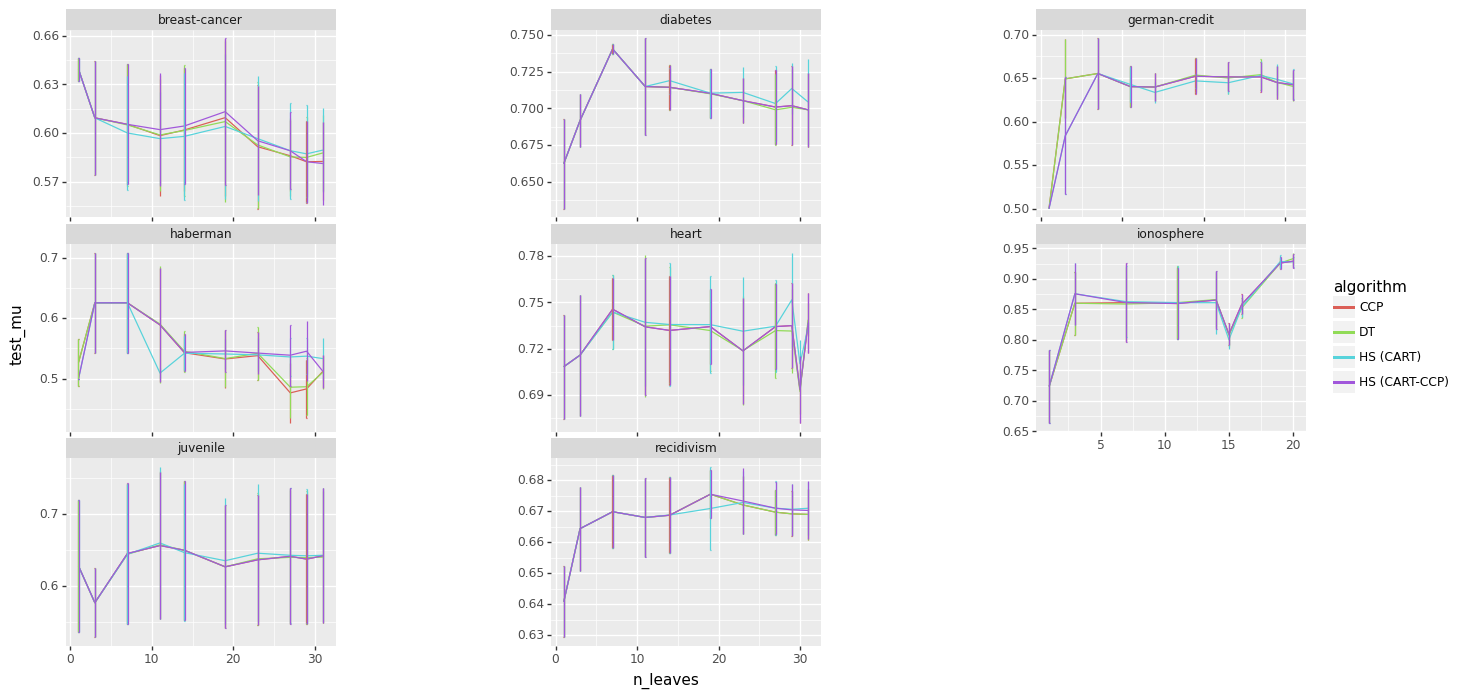

<ggplot: (8766376534365)>

In [ ]:
def plot_fig_4(res):
    res = res.copy()

    res_group = res.drop(["regularization", "max_leaves"], axis = 1).groupby(["task", "dataset", "algorithm", "scoring", "n_leaves"])
    res_mu = res_group.mean()
    res_mu.columns = ["train_mu", "test_mu"]
    res_std = res_group.std()
    res_std.columns = ["train_std", "test_std"]
    res = res_mu.join(res_std)
    res["test_min"] = res["test_mu"] - res["test_std"]
    res["test_max"] = res["test_mu"] + res["test_std"]
    res["train_min"] = res["train_mu"] - res["train_std"]
    res["train_max"] = res["train_mu"] + res["train_std"]
    res = res.reset_index()

    g = (ggplot(res, aes(x="n_leaves", y="test_mu", color="algorithm")) + 
    geom_line() +
    geom_errorbar(aes(ymin="test_min", ymax="test_max"), width=.2,
                 position=position_dodge(0.05)) +
    facet_wrap("dataset", scales="free") +
    theme(subplots_adjust={'wspace':0.8}) +
    theme(figure_size=(16, 8))
    )

    display(g)

plot_fig_4(classification_results)